In [1]:
import numpy as np
import cv2
import os
from tensorflow.contrib.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.optimizers import Adam,SGD
from numpy import genfromtxt
from tensorflow.keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from PIL import Image
import sys
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf
tf.test.gpu_device_name()

Using TensorFlow backend.


'/device:GPU:0'

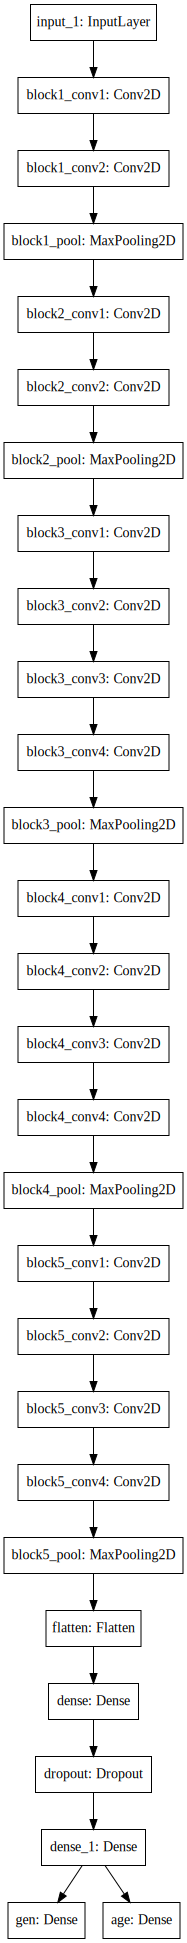

In [13]:
K.clear_session()
model = load_model('my_model[94,75].h5')
# def create_model():
#     input_im = Input(shape=(256,256,3))

#     x = Conv2D(96, kernel_size=7, activation='relu')(input_im)
#     x = MaxPooling2D(pool_size=(2, 2))(x)

#     x = Conv2D(256, kernel_size=5, activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
   

#     x = Conv2D(384, kernel_size=3, activation='relu')(x)
#     x = MaxPooling2D(pool_size=(2, 2))(x)
#     x = Dropout(0.25)(x)
  
    
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.25)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.25)(x)
   
#     x = Flatten()(x)
        
#     gen = Dense(2, activation='softmax')(x)    
#     age = Dense(8, activation='softmax')(x)

#     model = Model(inputs=input_im, outputs=[gen,age]) 

#     return model   
# model=create_model()

# model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
# usage : custom_gen(range(0,3000+1))

def custom_gen(_anns,use_range,batch_size):
    while True:
        image_data = []
        label_data_gender = []
        label_data_age = []
        start_indx = np.random.randint(low=use_range[0],high=use_range[-batch_size])
        
        # Read anns
        batch_row = _anns[start_indx:start_indx+batch_size]       
                    
        
        # Read images
        for row in batch_row:
            im = load_img('images/'+row[0]+'/'+row[2]+'.'+row[1],target_size=(256, 256,3))  #PIL Image          
            im = img_to_array(im) # Numpy
            im = im/255.
            image_data.append(im)               
            
            label_data_gender.append(np.fromstring(row[5], sep=' ')) # target gender
            label_data_age.append(np.fromstring(row[6], sep=' ')) # target gender
            
   
        image_data = np.array(image_data)
 
        
        yield( image_data, [label_data_gender,label_data_age] )       
        

In [3]:
# Read CSV annotations
train_anns = genfromtxt('anns/'+'train_anns.csv', delimiter=',',dtype=str)
val_anns = genfromtxt('anns/'+'val_anns.csv', delimiter=',',dtype=str)
np.random.shuffle(train_anns)
np.random.shuffle(val_anns)

train_range = range(0,100+1) # all = 10000
val_range = range(0,200+1) # all = 1332

print('train_range : ',train_range[0],'-',train_range[-1],\
      '\nval_range',val_range[0],'-',val_range[-1])
batch_size = 4

train_range :  0 - 100 
val_range 0 - 200


# TRAIN

In [17]:
early_stopping = EarlyStopping(monitor='val_dense_3_acc', min_delta=0.05, patience=0, verbose=1)
history = model.fit_generator(
        custom_gen(train_anns,train_range,batch_size), 
        steps_per_epoch=max(1, len(train_range)//batch_size),
        epochs=1,        
        validation_data=custom_gen(val_anns,val_range,batch_size),
        validation_steps=max(1, len(val_range)//batch_size),
        callbacks=[early_stopping])

Epoch 1/1
25/25 [==============================] - 58s 2s/step - loss: 2.8154 - dense_3_loss: 0.7040 - dense_4_loss: 2.1115 - dense_3_acc: 0.4700 - dense_4_acc: 0.2600 - val_loss: 2.7490 - val_dense_3_loss: 0.6950 - val_dense_4_loss: 2.0539 - val_dense_3_acc: 0.4800 - val_dense_4_acc: 0.2600


# TEST

True 	 m 		| m 1.0
True 	 (25-32) 	| (25-32) 0.9969221


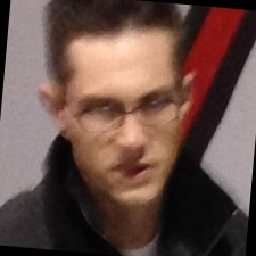

True 	 m 		| m 0.99999666
True 	 (0-2) 	| (0-2) 0.9999999


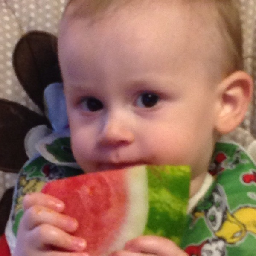

False 	 f 		| m 0.9424684
True 	 (25-32) 	| (25-32) 0.5623054


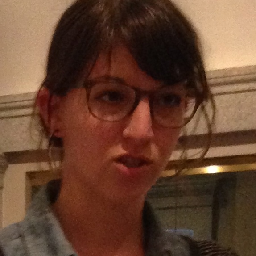

True 	 m 		| m 1.0
False 	 (4-6) 	| (8-12) 0.59824586


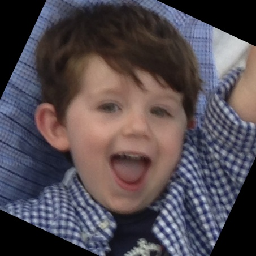

True 	 f 		| f 1.0
True 	 (25-32) 	| (25-32) 0.9994289


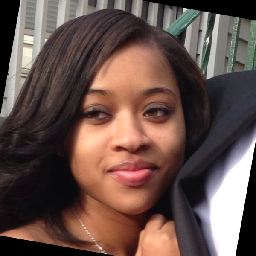

True 	 m 		| m 0.9998186
True 	 (60-100) 	| (60-100) 0.9995432


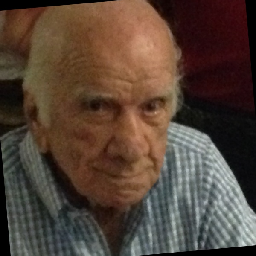

True 	 m 		| m 1.0
True 	 (38-43) 	| (38-43) 0.99281454


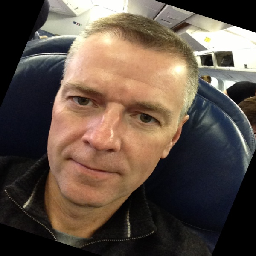

True 	 f 		| f 0.9999939
False 	 (8-12) 	| (25-32) 0.6988696


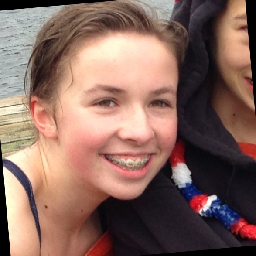

True 	 f 		| f 1.0
False 	 (38-43) 	| (25-32) 0.93134516


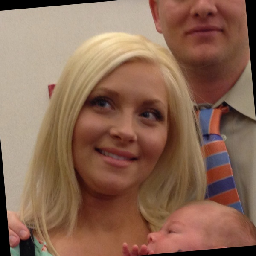

True 	 m 		| m 1.0
True 	 (25-32) 	| (25-32) 0.9999995


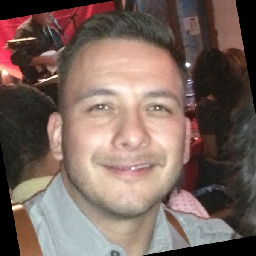

True 	 f 		| f 0.9572508
True 	 (25-32) 	| (25-32) 0.78685445


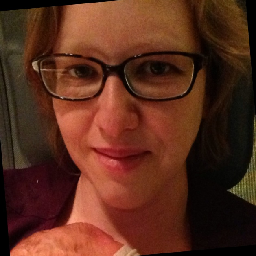

True 	 f 		| f 1.0
False 	 (15-20) 	| (8-12) 0.89755565


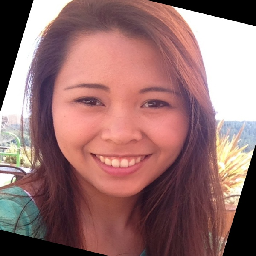

True 	 f 		| f 1.0
True 	 (25-32) 	| (25-32) 0.99991155


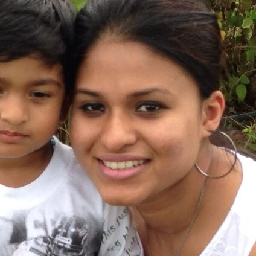

True 	 m 		| m 1.0
True 	 (25-32) 	| (25-32) 0.995129


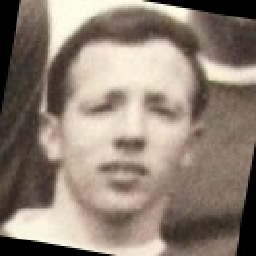

True 	 f 		| f 0.9997433
True 	 (60-100) 	| (60-100) 0.9973718


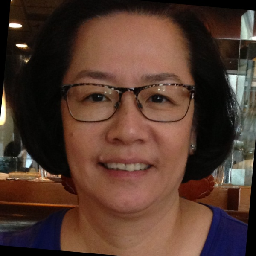

True 	 f 		| f 0.9999994
True 	 (60-100) 	| (60-100) 0.79644614


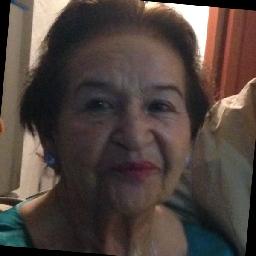

True 	 m 		| m 0.9986046
False 	 (25-32) 	| (38-43) 0.7416667


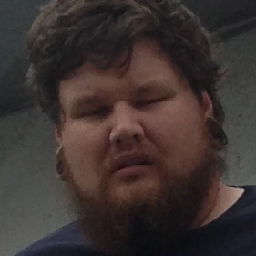

True 	 m 		| m 0.9999516
True 	 (0-2) 	| (0-2) 0.99999


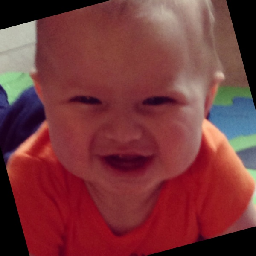

True 	 f 		| f 1.0
False 	 (38-43) 	| (25-32) 0.8490365


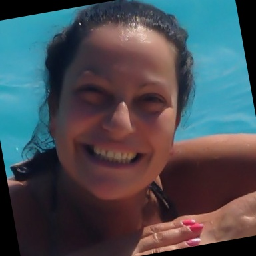

True 	 m 		| m 0.9997867
True 	 (25-32) 	| (25-32) 0.89602363


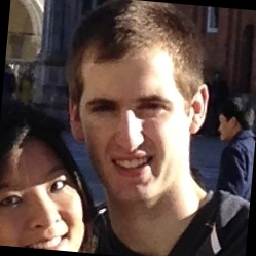


correct-gender :  19 prob-1.00 
correct-age :  14 prob-0.74


In [17]:
gender_dict = ['m','f']
age_dict = ['(0-2)','(4-6)','(8-12)','(15-20)','(25-32)','(38-43)','(48-53)','(60-100)']

true_gen = 0
true_age = 0 
for i in range(0,20):
#     sys.stdout.write("\r" + 'test images : '+str(i))
#     sys.stdout.flush()
   
    rowp = val_anns[i]
    im_ori = load_img('images/'+rowp[0]+'/'+rowp[2]+'.'+rowp[1],target_size=(256, 256,3))

    im = img_to_array(im_ori)
    im = im/255.
    im = np.expand_dims(im, axis=0)

    genderp,agep = model.predict(im)
    
    if rowp[4]==gender_dict[genderp.argmax()]:
        true_gen += 1
    if rowp[3]==age_dict[agep[0].argmax()]:
        true_age += 1
    
    
    print(rowp[4]==gender_dict[genderp.argmax()],'\t',rowp[4],'\t\t|',gender_dict[genderp.argmax()],np.amax(genderp))
    print(rowp[3]==age_dict[agep.argmax()],'\t',rowp[3],'\t|',age_dict[agep.argmax()],np.amax(agep))
    display(im_ori)
   
print('\ncorrect-gender : ','{:d} prob-{:.2f}'.format(true_gen,true_gen/i),\
      '\ncorrect-age : ','{:d} prob-{:.2f}'.format(true_age,true_age/i)) 

In [ ]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
reset_weights(model)

In [ ]:
print (model.get_weights())

In [ ]:
model.save('my_model.h5')

In [3]:
model = load_model('my_model256.h5')